<h1 style='color:purple' align='center'>Data Science Regression Project: Predicting Home Prices in Banglore</h1>

Dataset is downloaded from here: https://www.kaggle.com/amitabhajoy/bengaluru-house-price-data

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib 
matplotlib.rcParams["figure.figsize"] = (20,10)

<h2 style='color:blue'>Data Load: Load banglore home prices into a dataframe</h2>

In [2]:
df1 = pd.read_csv("modified_pune.csv")
df1.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Alandi Road,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Ambegaon Budruk,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Anandnagar,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Aundh,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Aundh Road,2 BHK,NaN,1200,2.0,1.0,51.00


In [3]:
df1.shape

(13320, 9)

In [4]:
df1.columns

Index(['area_type', 'availability', 'location', 'size', 'society',
       'total_sqft', 'bath', 'balcony', 'price'],
      dtype='object')

In [5]:
df1['area_type'].unique()

array(['Super built-up  Area', 'Plot  Area', 'Built-up  Area',
       'Carpet  Area'], dtype=object)

In [6]:
df1['area_type'].value_counts()

area_type
Super built-up  Area    8790
Built-up  Area          2418
Plot  Area              2025
Carpet  Area              87
Name: count, dtype: int64

**Drop features that are not required to build our model**

In [7]:
df2 = df1.drop(['area_type','society','balcony','availability'],axis='columns')
df2.shape

(13320, 5)

<h2 style='color:blue'>Data Cleaning: Handle NA values</h2>

In [8]:
df2.isnull().sum()

location       1
size          16
total_sqft     0
bath          73
price          0
dtype: int64

In [9]:
df2.shape

(13320, 5)

In [10]:
df3 = df2.dropna()
df3.isnull().sum()

location      0
size          0
total_sqft    0
bath          0
price         0
dtype: int64

In [11]:
df3.shape

(13246, 5)

<h2 style='color:blue'>Feature Engineering</h2>

**Add new feature(integer) for bhk (Bedrooms Hall Kitchen)**

In [12]:
df3['bhk'] = df3['size'].apply(lambda x: int(x.split(' ')[0]))
df3.bhk.unique()

C:\Users\tejas\AppData\Local\Temp\ipykernel_27396\2716584372.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['bhk'] = df3['size'].apply(lambda x: int(x.split(' ')[0]))


array([ 2,  4,  3,  6,  1,  8,  7,  5, 11,  9, 27, 10, 19, 16, 43, 14, 12,
       13, 18], dtype=int64)

**Explore total_sqft feature**

In [13]:
def is_float(x):
    try:
        float(x)
    except:
        return False
    return True

In [14]:
2+3

5

In [15]:
df3[~df3['total_sqft'].apply(is_float)].head(10)

,location,size,total_sqft,bath,price,bhk
30,Gultekdi,4 BHK,2100 - 2850,4.0,186.000,4
122,Ganeshkhind,4 BHK,3067 - 8156,4.0,477.000,4
137,Khadaki,2 BHK,1042 - 1105,2.0,54.005,2
165,Prabhat Road,2 BHK,1145 - 1340,2.0,43.490,2
188,Wakadewadi,2 BHK,1015 - 1540,2.0,56.800,2
410,Ganeshkhind,1 BHK,34.46Sq. Meter,1.0,18.500,1
549,Prabhat Road,2 BHK,1195 - 1440,2.0,63.770,2
648,Raviwar Peth,9 Bedroom,4125Perch,9.0,265.000,9
661,Tilak Road,2 BHK,1120 - 1145,2.0,48.130,2
672,Alandi Road,4 Bedroom,3090 - 5002,4.0,445.000,4


**Above shows that total_sqft can be a range (e.g. 2100-2850). For such case we can just take average of min and max value in the range. There are other cases such as 34.46Sq. Meter which one can convert to square ft using unit conversion. I am going to just drop such corner cases to keep things simple**

In [16]:
def convert_sqft_to_num(x):
    tokens = x.split('-')
    if len(tokens) == 2:
        return (float(tokens[0])+float(tokens[1]))/2
    try:
        return float(x)
    except:
        return None   

In [17]:
df4 = df3.copy()
df4.total_sqft = df4.total_sqft.apply(convert_sqft_to_num)
df4 = df4[df4.total_sqft.notnull()]
df4.head(2)

,location,size,total_sqft,bath,price,bhk
0,Alandi Road,2 BHK,1056.0,2.0,39.07,2
1,Ambegaon Budruk,4 Bedroom,2600.0,5.0,120.00,4


**For below row, it shows total_sqft as 2475 which is an average of the range 2100-2850**

In [18]:
df4.loc[30]

location      Gultekdi
size             4 BHK
total_sqft      2475.0
bath               4.0
price            186.0
bhk                  4
Name: 30, dtype: object

In [19]:
(2100+2850)/2

2475.0

<h2 style="color:blue">Feature Engineering</h2>

**Add new feature called price per square feet**

In [20]:
df5 = df4.copy()
df5['price_per_sqft'] = df5['price']*100000/df5['total_sqft']
df5.head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Alandi Road,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Ambegaon Budruk,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Anandnagar,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Aundh,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Aundh Road,2 BHK,1200.0,2.0,51.00,2,4250.000000


In [21]:
df5_stats = df5['price_per_sqft'].describe()
df5_stats

count    1.320000e+04
mean     7.920878e+03
std      1.067272e+05
min      2.678298e+02
25%      4.268165e+03
50%      5.438331e+03
75%      7.317073e+03
max      1.200000e+07
Name: price_per_sqft, dtype: float64

In [22]:
df5.to_csv("bhp.csv",index=False)

**Examine locations which is a categorical variable. We need to apply dimensionality reduction technique here to reduce number of locations**

In [23]:
df5.location = df5.location.apply(lambda x: x.strip())
location_stats = df5['location'].value_counts(ascending=False)
location_stats

location
Kasba Peth         139
Bibvewadi          139
Laxmi Road         139
Ambegaon Budruk    139
Nana Peth          139
                  ... 
Fatima Nagar       135
Model colony       135
Wakadewadi         134
Vadgaon Budruk     133
other                1
Name: count, Length: 97, dtype: int64

In [24]:
location_stats.values.sum()

13200

In [25]:
len(location_stats[location_stats>10])

96

In [26]:
len(location_stats)

97

In [27]:
len(location_stats[location_stats<=10])

1

<h2 style="color:blue">Dimensionality Reduction</h2>

**Any location having less than 10 data points should be tagged as "other" location. This way number of categories can be reduced by huge amount. Later on when we do one hot encoding, it will help us with having fewer dummy columns**

In [28]:
location_stats_less_than_10 = location_stats[location_stats<=10]
location_stats_less_than_10

location
other    1
Name: count, dtype: int64

In [29]:
len(df5.location.unique())

97

In [30]:
df5.location = df5.location.apply(lambda x: 'other' if x in location_stats_less_than_10 else x)
len(df5.location.unique())

97

In [31]:
df5.head(10)

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Alandi Road,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Ambegaon Budruk,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Anandnagar,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Aundh,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Aundh Road,2 BHK,1200.0,2.0,51.00,2,4250.000000
5,Balaji Nagar,2 BHK,1170.0,2.0,38.00,2,3247.863248
6,Baner,4 BHK,2732.0,4.0,204.00,4,7467.057101
7,Baner road,4 BHK,3300.0,4.0,600.00,4,18181.818182
8,Bhandarkar Road,3 BHK,1310.0,3.0,63.25,3,4828.244275
9,Bhavani Peth,6 Bedroom,1020.0,6.0,370.00,6,36274.509804


<h2 style="color:blue">Outlier Removal Using Business Logic</h2>

**As a data scientist when you have a conversation with your business manager (who has expertise in real estate), he will tell you that normally square ft per bedroom is 300 (i.e. 2 bhk apartment is minimum 600 sqft. If you have for example 400 sqft apartment with 2 bhk than that seems suspicious and can be removed as an outlier. We will remove such outliers by keeping our minimum thresold per bhk to be 300 sqft**

In [32]:
df5[df5.total_sqft/df5.bhk<300].head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
9,Bhavani Peth,6 Bedroom,1020.0,6.0,370.0,6,36274.509804
45,Kondhwa Budruk,8 Bedroom,600.0,9.0,200.0,8,33333.333333
58,Mundhawa,6 Bedroom,1407.0,4.0,150.0,6,10660.980810
68,Pirangut,8 Bedroom,1350.0,7.0,85.0,8,6296.296296
70,Pune Railway Station,3 Bedroom,500.0,3.0,100.0,3,20000.000000


**Check above data points. We have 6 bhk apartment with 1020 sqft. Another one is 8 bhk and total sqft is 600. These are clear data errors that can be removed safely**

In [33]:
df5.shape

(13200, 7)

In [34]:
df6 = df5[~(df5.total_sqft/df5.bhk<300)]
df6.shape

(12456, 7)

<h2 style='color:blue'>Outlier Removal Using Standard Deviation and Mean</h2>

In [35]:
df6.price_per_sqft.describe()

count     12456.000000
mean       6308.628922
std        4168.075333
min         267.829813
25%        4210.526316
50%        5294.117647
75%        6916.666667
max      176470.588235
Name: price_per_sqft, dtype: float64

**Here we find that min price per sqft is 267 rs/sqft whereas max is 12000000, this shows a wide variation in property prices. We should remove outliers per location using mean and one standard deviation**

In [36]:
def remove_pps_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('location'):
        m = np.mean(subdf.price_per_sqft)
        st = np.std(subdf.price_per_sqft)
        reduced_df = subdf[(subdf.price_per_sqft>(m-st)) & (subdf.price_per_sqft<=(m+st))]
        df_out = pd.concat([df_out,reduced_df],ignore_index=True)
    return df_out
df7 = remove_pps_outliers(df6)
df7.shape

(10883, 7)

**Let's check if for a given location how does the 2 BHK and 3 BHK property prices look like**

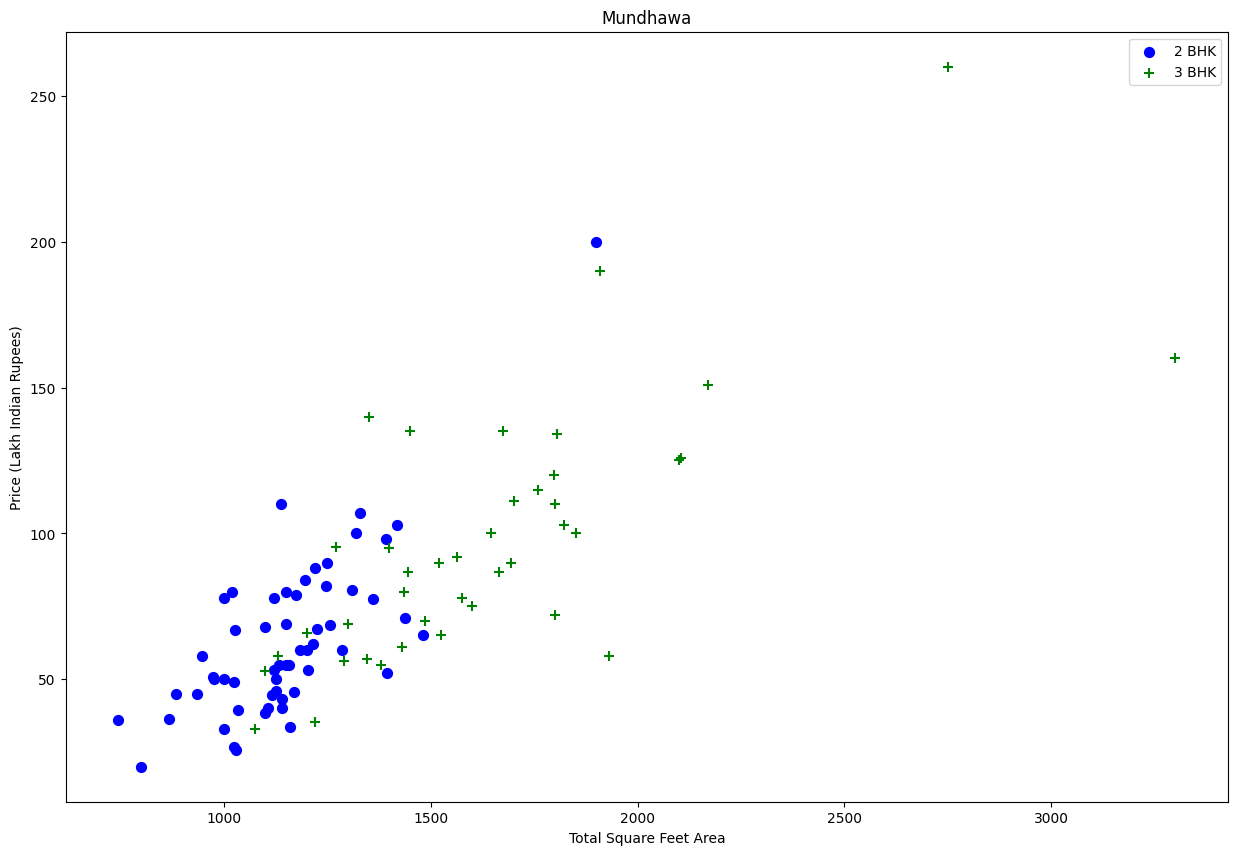

In [37]:
def plot_scatter_chart(df,location):
    bhk2 = df[(df.location==location) & (df.bhk==2)]
    bhk3 = df[(df.location==location) & (df.bhk==3)]
    matplotlib.rcParams['figure.figsize'] = (15,10)
    plt.scatter(bhk2.total_sqft,bhk2.price,color='blue',label='2 BHK', s=50)
    plt.scatter(bhk3.total_sqft,bhk3.price,marker='+', color='green',label='3 BHK', s=50)
    plt.xlabel("Total Square Feet Area")
    plt.ylabel("Price (Lakh Indian Rupees)")
    plt.title(location)
    plt.legend()
    
plot_scatter_chart(df7,"Mundhawa")

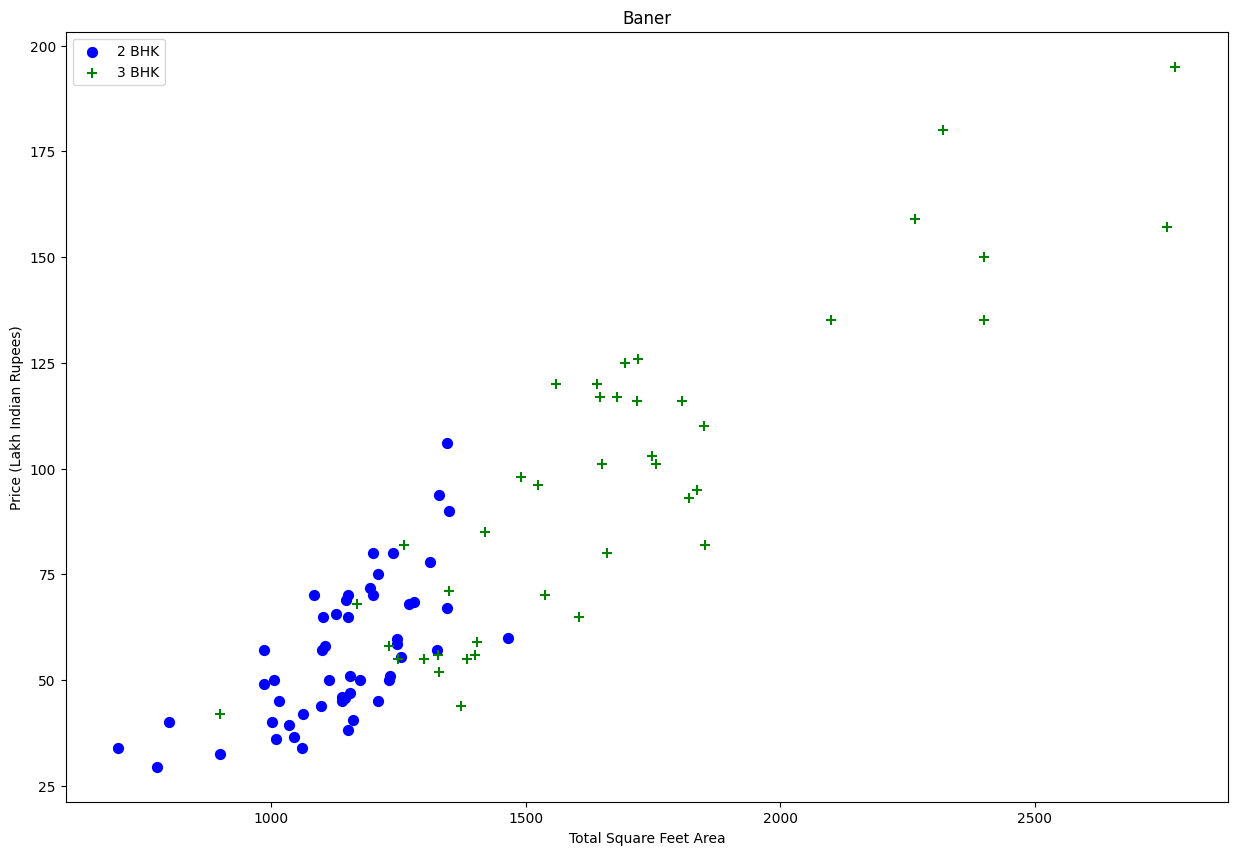

In [38]:
plot_scatter_chart(df7,"Baner")

**We should also remove properties where for same location, the price of (for example) 3 bedroom apartment is less than 2 bedroom apartment (with same square ft area). What we will do is for a given location, we will build a dictionary of stats per bhk, i.e.**
```
{
    '1' : {
        'mean': 4000,
        'std: 2000,
        'count': 34
    },
    '2' : {
        'mean': 4300,
        'std: 2300,
        'count': 22
    },    
}
```
**Now we can remove those 2 BHK apartments whose price_per_sqft is less than mean price_per_sqft of 1 BHK apartment**

In [39]:
def remove_bhk_outliers(df):
    exclude_indices = np.array([])
    for location, location_df in df.groupby('location'):
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby('bhk'):
            bhk_stats[bhk] = {
                'mean': np.mean(bhk_df.price_per_sqft),
                'std': np.std(bhk_df.price_per_sqft),
                'count': bhk_df.shape[0]
            }
        for bhk, bhk_df in location_df.groupby('bhk'):
            stats = bhk_stats.get(bhk-1)
            if stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.price_per_sqft<(stats['mean'])].index.values)
    return df.drop(exclude_indices,axis='index')
df8 = remove_bhk_outliers(df7)
# df8 = df7.copy()
df8.shape

(7543, 7)

**Plot same scatter chart again to visualize price_per_sqft for 2 BHK and 3 BHK properties**

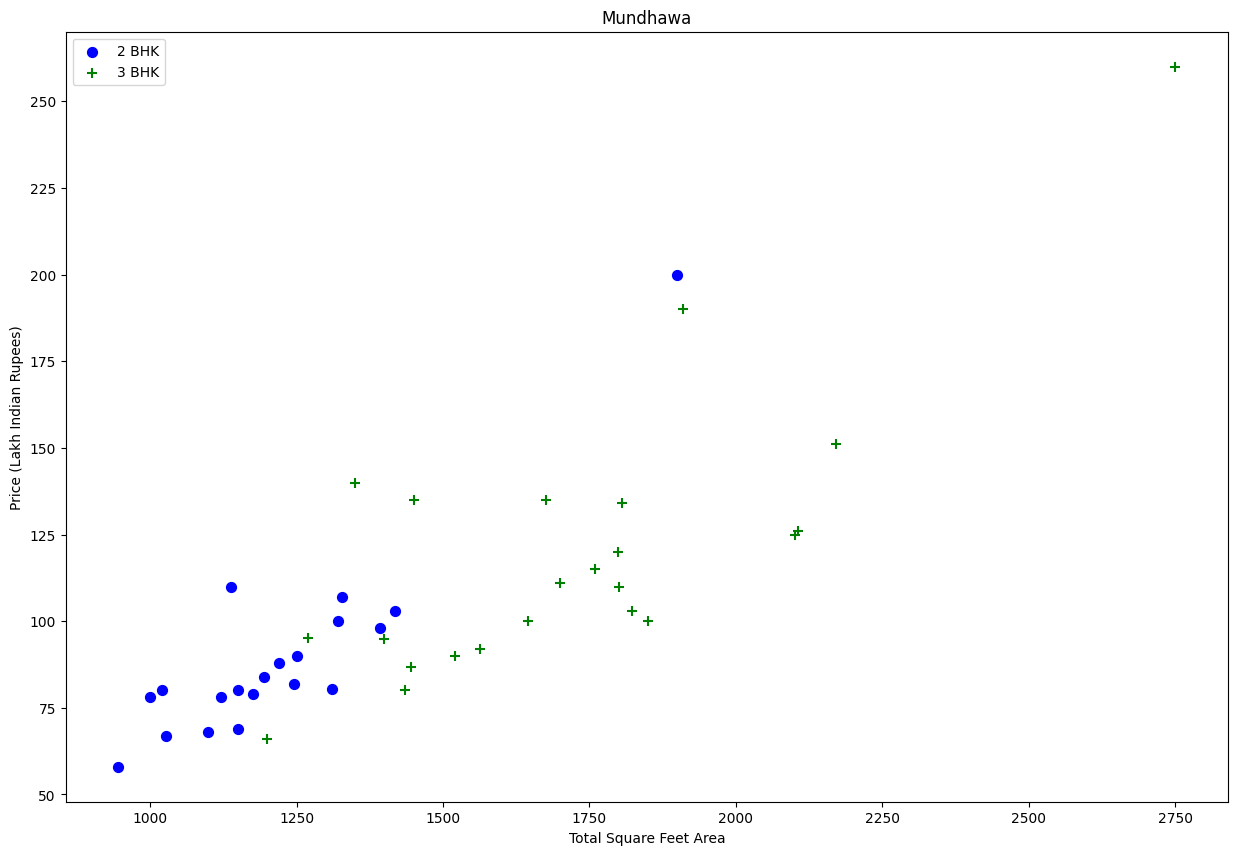

In [40]:
plot_scatter_chart(df8,"Mundhawa")

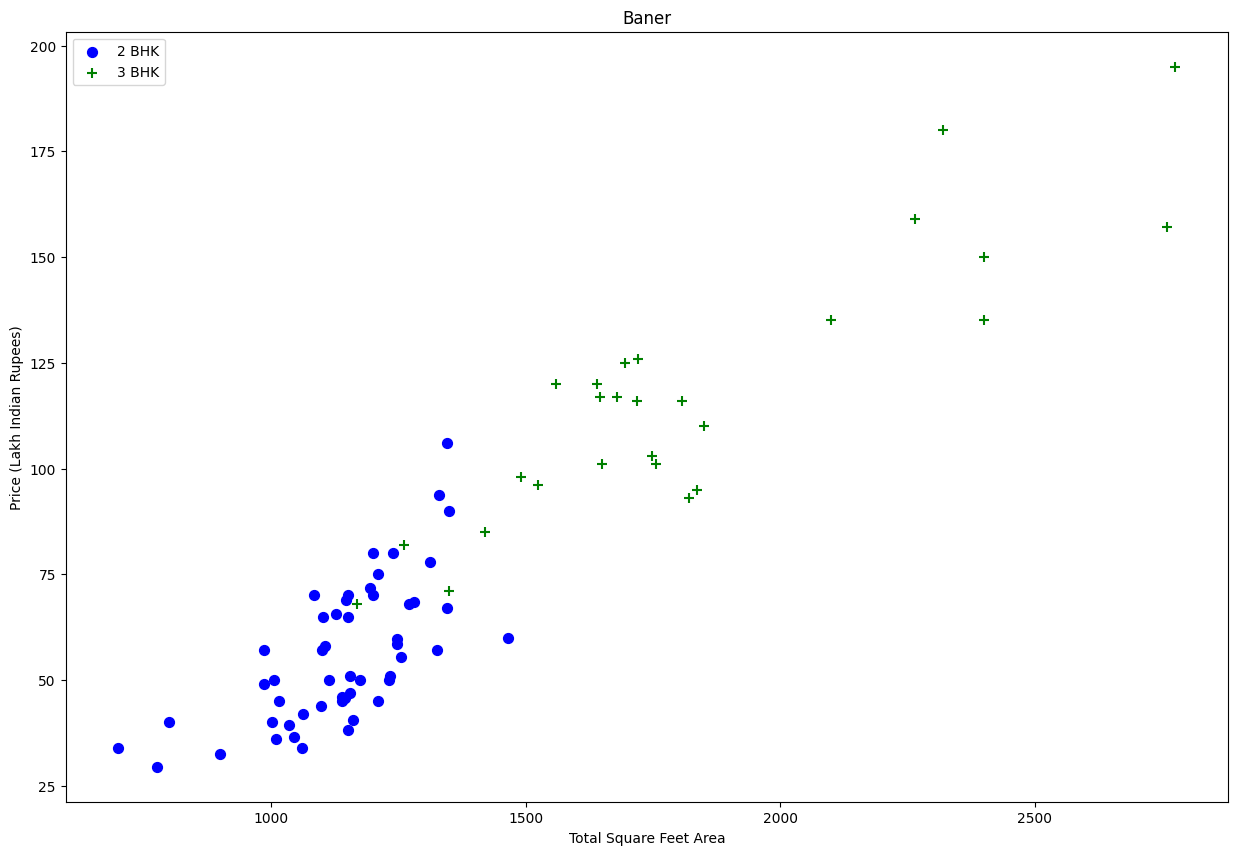

In [41]:
plot_scatter_chart(df8,"Baner")

**Based on above charts we can see that data points highlighted in red below are outliers and they are being removed due to remove_bhk_outliers function**

<h3 style='color:green'>Before and after outlier removal: Rajaji Nagar</h3>

<img src="rajaji_nagar_outliers.png"></img>

<h3 style='color:green'>Before and after outlier removal: Hebbal</h3>

<img src="hebbal_outliers.png"></img>

Text(0, 0.5, 'Count')

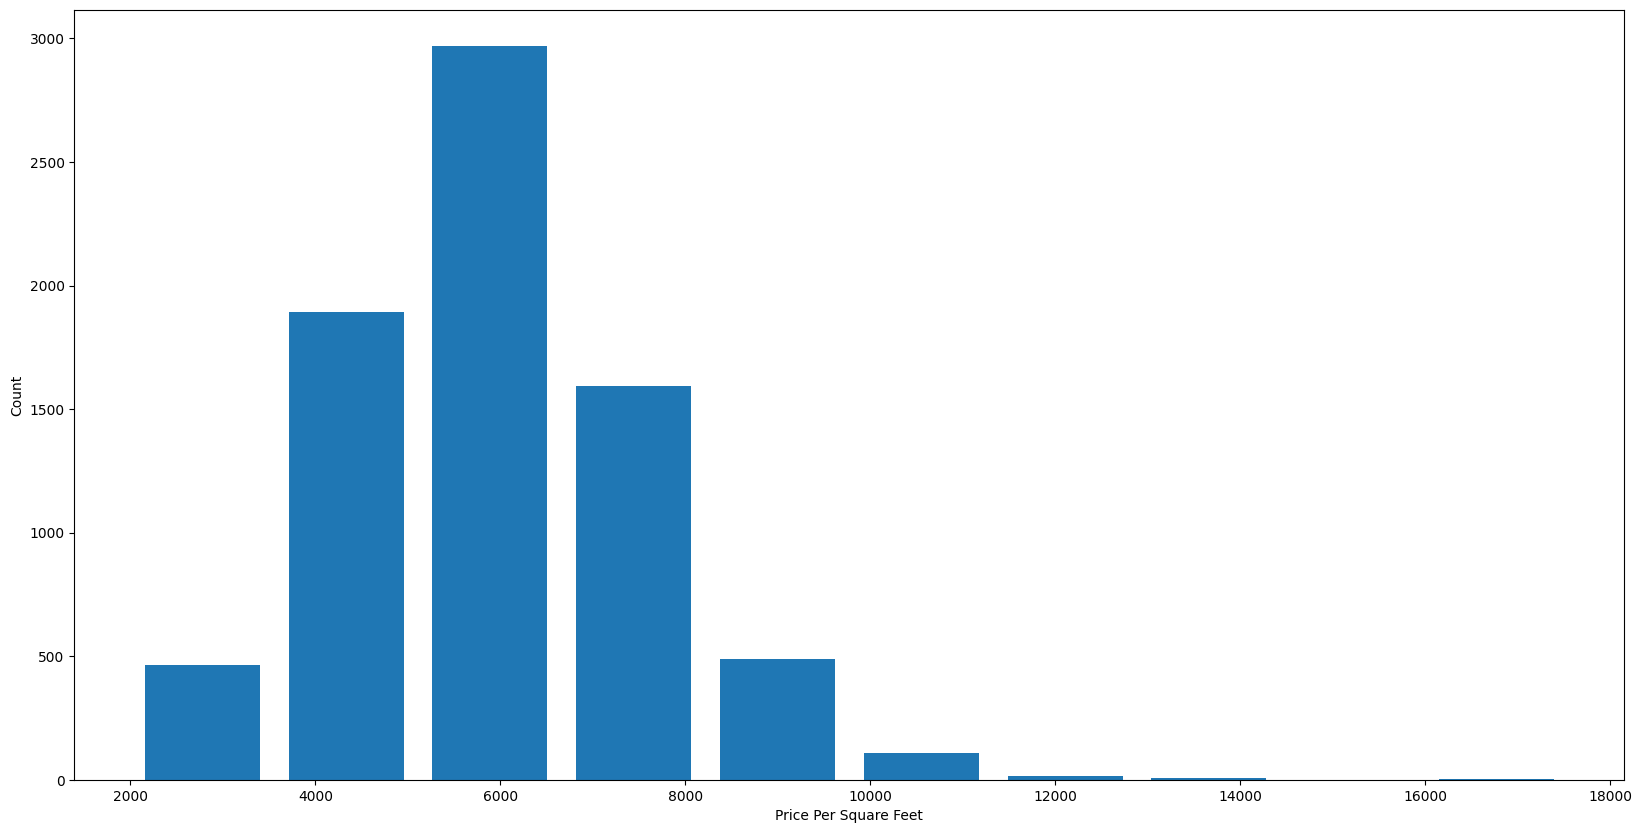

In [42]:
import matplotlib
matplotlib.rcParams["figure.figsize"] = (20,10)
plt.hist(df8.price_per_sqft,rwidth=0.8)
plt.xlabel("Price Per Square Feet")
plt.ylabel("Count")

<h2 style='color:blue'>Outlier Removal Using Bathrooms Feature</h2>

In [43]:
df8.bath.unique()

array([ 2.,  4.,  3.,  5.,  9.,  1.,  6.,  7.,  8., 12., 13., 16.])

Text(0, 0.5, 'Count')

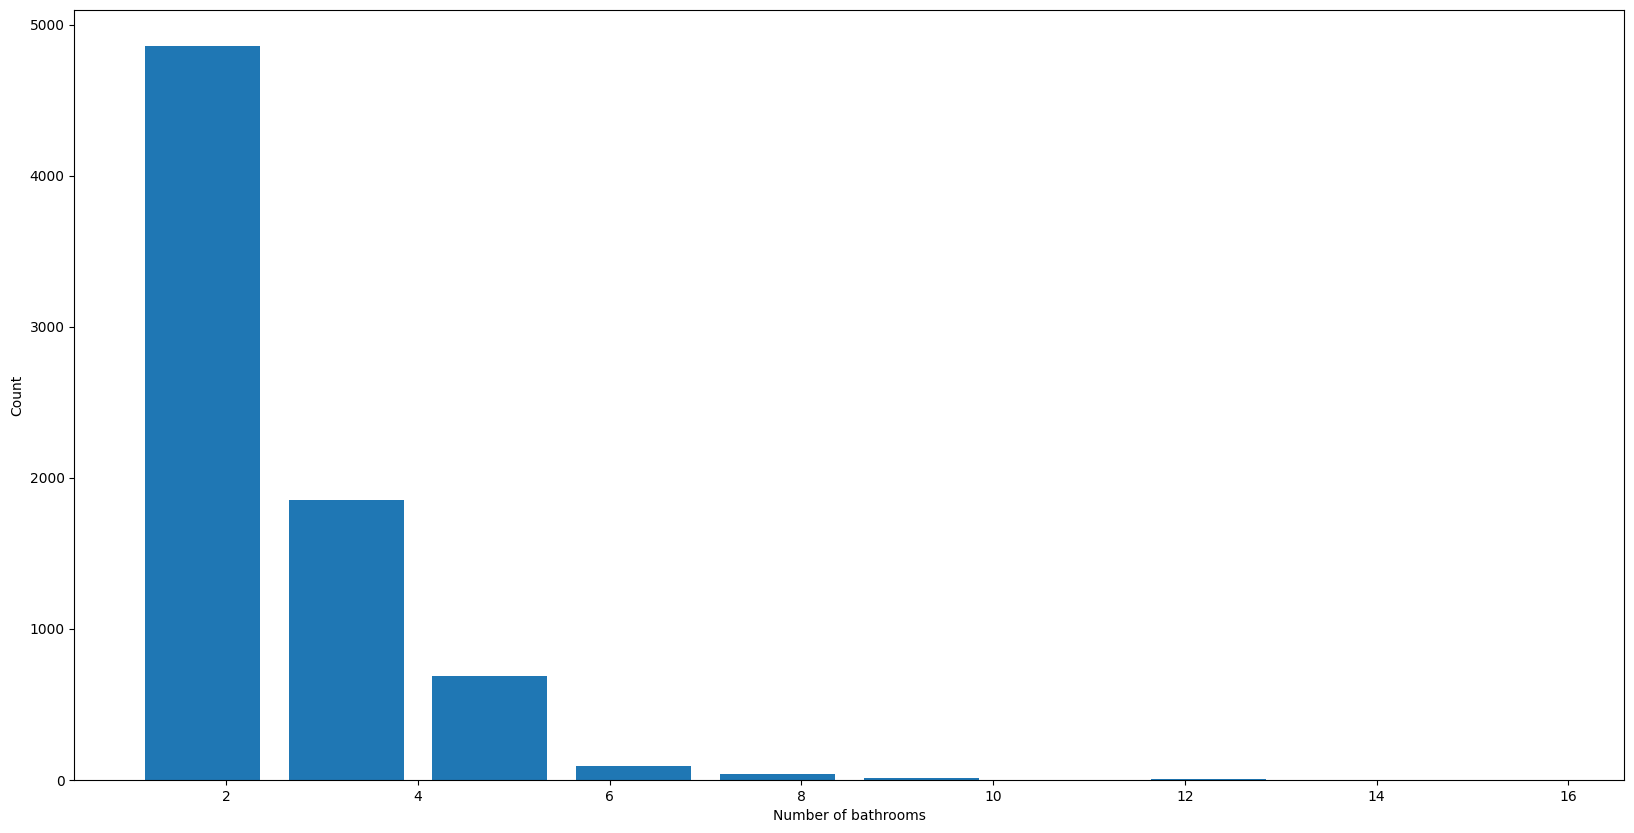

In [44]:
plt.hist(df8.bath,rwidth=0.8)
plt.xlabel("Number of bathrooms")
plt.ylabel("Count")

In [45]:
df8[df8.bath>10]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
1211,Bibvewadi,11 BHK,6000.0,12.0,150.0,11,2500.000000
2637,Fatima Nagar,10 BHK,12000.0,12.0,525.0,10,4375.000000
5265,Kondhwa Khurd,13 BHK,5425.0,13.0,275.0,13,5069.124424
6350,Model colony,16 BHK,10000.0,16.0,550.0,16,5500.000000
10389,Wagholi,10 BHK,4000.0,12.0,160.0,10,4000.000000


**It is unusual to have 2 more bathrooms than number of bedrooms in a home**

In [46]:
df8[df8.bath>df8.bhk+2]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
772,Baner,3 BHK,1806.0,6.0,116.0,3,6423.034330
3067,Ghorpade Peth,6 BHK,11338.0,9.0,1000.0,6,8819.897689
4231,Karve Nagar,4 Bedroom,7000.0,8.0,450.0,4,6428.571429


**Again the business manager has a conversation with you (i.e. a data scientist) that if you have 4 bedroom home and even if you have bathroom in all 4 rooms plus one guest bathroom, you will have total bath = total bed + 1 max. Anything above that is an outlier or a data error and can be removed**

In [47]:
df9 = df8[df8.bath<df8.bhk+2]
df9.shape

(7479, 7)

In [48]:
df9.head(2)

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Alandi Road,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Alandi Road,4 Bedroom,2894.0,4.0,245.00,4,8465.791292


In [49]:
df10 = df9.drop(['size','price_per_sqft'],axis='columns')
df10.head(3)

,location,total_sqft,bath,price,bhk
0,Alandi Road,1056.0,2.0,39.07,2
1,Alandi Road,2894.0,4.0,245.00,4
2,Alandi Road,1084.0,2.0,50.00,2


<h2 style='color:blue'>Use One Hot Encoding For Location</h2>

In [50]:
dummies = pd.get_dummies(df10.location)
dummies.head(3)

,Alandi Road,Ambegaon Budruk,Anandnagar,Aundh,Aundh Road,Balaji Nagar,Baner,Baner road,Bhandarkar Road,Bhavani Peth,...,Uruli Devachi,Vadgaon Budruk,Viman Nagar,Vishrant Wadi,Wadgaon Sheri,Wagholi,Wakadewadi,Wanowrie,Warje,Yerawada
0,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [51]:
df11 = pd.concat([df10,dummies.drop('Yerawada',axis='columns')],axis='columns')
df11.head()

,location,total_sqft,bath,price,bhk,Alandi Road,Ambegaon Budruk,Anandnagar,Aundh,Aundh Road,...,Tilak Road,Uruli Devachi,Vadgaon Budruk,Viman Nagar,Vishrant Wadi,Wadgaon Sheri,Wagholi,Wakadewadi,Wanowrie,Warje
0,Alandi Road,1056.0,2.0,39.07,2,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,Alandi Road,2894.0,4.0,245.00,4,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,Alandi Road,1084.0,2.0,50.00,2,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,Alandi Road,1230.0,2.0,80.00,2,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,Alandi Road,1750.0,3.0,130.00,3,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [52]:
df12 = df11.drop('location',axis='columns')
df12.head(2)

,total_sqft,bath,price,bhk,Alandi Road,Ambegaon Budruk,Anandnagar,Aundh,Aundh Road,Balaji Nagar,...,Tilak Road,Uruli Devachi,Vadgaon Budruk,Viman Nagar,Vishrant Wadi,Wadgaon Sheri,Wagholi,Wakadewadi,Wanowrie,Warje
0,1056.0,2.0,39.07,2,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,2894.0,4.0,245.00,4,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


<h2 style='color:blue'>Build a Model Now...</h2>

In [53]:
df12.shape

(7479, 99)

In [54]:
X = df12.drop(['price'],axis='columns')
X.head(3)

,total_sqft,bath,bhk,Alandi Road,Ambegaon Budruk,Anandnagar,Aundh,Aundh Road,Balaji Nagar,Baner,...,Tilak Road,Uruli Devachi,Vadgaon Budruk,Viman Nagar,Vishrant Wadi,Wadgaon Sheri,Wagholi,Wakadewadi,Wanowrie,Warje
0,1056.0,2.0,2,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,2894.0,4.0,4,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,1084.0,2.0,2,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [55]:
X.shape

(7479, 98)

In [56]:
y = df12.price
y.head(3)

0     39.07
1    245.00
2     50.00
Name: price, dtype: float64

In [57]:
len(y)

7479

In [58]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=10)

In [59]:
from sklearn.linear_model import LinearRegression
lr_clf = LinearRegression()
lr_clf.fit(X_train,y_train)
lr_clf.score(X_test,y_test)

0.8234642712561874

<h2 style='color:blue'>Use K Fold cross validation to measure accuracy of our LinearRegression model</h2>

In [60]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

cross_val_score(LinearRegression(), X, y, cv=cv)

array([0.87729294, 0.87158074, 0.82825079, 0.89763339, 0.81068616])

**We can see that in 5 iterations we get a score above 80% all the time. This is pretty good but we want to test few other algorithms for regression to see if we can get even better score. We will use GridSearchCV for this purpose**

<h2 style='color:blue'>Find best model using GridSearchCV</h2>

In [61]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression

# Define the parameter grid for LinearRegression (excluding 'normalize')
params = {
    'fit_intercept': [True, False],
    'copy_X': [True, False],
    'positive': [True, False]
}

# Create a dictionary of algorithms and their configurations
algos = {
    'LinearRegression': {
        'model': LinearRegression(),
        'params': params
    }
}

# Define a function to find the best model using GridSearchCV
def find_best_model_using_gridsearchcv(X, y):
    scores = []
    cv = 5  # Number of cross-validation folds

    for algo_name, config in algos.items():
        gs = GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(X, y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })
    return pd.DataFrame(scores, columns=['model', 'best_score', 'best_params'])

# Call the function with your X and y data
find_best_model_using_gridsearchcv(X, y)


,model,best_score,best_params
0,LinearRegression,0.812744,"{'copy_X': True, 'fit_intercept': False, 'posi..."


**Based on above results we can say that LinearRegression gives the best score. Hence we will use that.**

<h2 style='color:blue'>Test the model for few properties</h2>

In [62]:
def predict_price(location,sqft,bath,bhk):    
    loc_index = np.where(X.columns==location)[0][0]

    x = np.zeros(len(X.columns))
    x[0] = sqft
    x[1] = bath
    x[2] = bhk
    if loc_index >= 0:
        x[loc_index] = 1

    return lr_clf.predict([x])[0]

In [64]:
predict_price('Baner',1000, 2, 2)

C:\Users\tejas\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


51.05921852361469

In [68]:
predict_price('Baner',1000, 3, 3)

C:\Users\tejas\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


53.58359018108628

In [67]:
predict_price('Alandi Road',1000, 2, 2)

C:\Users\tejas\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


52.65844611969055

In [69]:
predict_price('Alandi Road',1000, 3, 3)

C:\Users\tejas\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


55.18281777716214

<h2 style='color:blue'>Export the tested model to a pickle file</h2>

In [70]:
import pickle
with open('banglore_home_prices_model.pickle','wb') as f:
    pickle.dump(lr_clf,f)

<h2 style='color:blue'>Export location and column information to a file that will be useful later on in our prediction application</h2>

In [71]:
import json
columns = {
    'data_columns' : [col.lower() for col in X.columns]
}
with open("columns.json","w") as f:
    f.write(json.dumps(columns))